## RAG working as an Agentic format

In [1]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

In [2]:
api_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=200)
wiki_tool = WikipediaQueryRun(api_wrapper=api_wrapper)
wiki_tool

WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'C:\\Users\\hp\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=1, lang='en', load_all_available_meta=False, doc_content_chars_max=200))

In [3]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings import SentenceTransformerEmbeddings

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [4]:
loader = WebBaseLoader("https://docs.langchain.com/oss/python/langchain/overview")
docs = loader.load()

In [5]:
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=200)
splitted_docs = splitter.split_documents(docs)

In [6]:
embedd = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
vct_store = FAISS.from_documents(splitted_docs, embedd)
vct_store

C:\Users\hp\AppData\Local\Temp\ipykernel_22652\2096566617.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embedd = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")


In [7]:
retriever = vct_store.as_retriever()
retriever

VectorStoreRetriever(tags=['FAISS', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x00000216DBFA8E50>, search_kwargs={})

In [8]:
from langchain_classic.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(retriever, "langchain_search",
                     "Search and return information about Langchain and Langsmith")

retriever_tool.name

'langchain_search'

## Arxiv tool

In [9]:
from langchain_community.utilities import ArxivAPIWrapper
from langchain_community.tools import ArxivQueryRun

arxiv_wrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=200)
arxiv = ArxivQueryRun(api_wrapper=arxiv_wrapper)
arxiv.name

'arxiv'

In [10]:
tools = [wiki_tool, arxiv, retriever_tool]
tools

[WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'C:\\Users\\hp\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=1, lang='en', load_all_available_meta=False, doc_content_chars_max=200)),
 ArxivQueryRun(api_wrapper=ArxivAPIWrapper(arxiv_search=<class 'arxiv.Search'>, arxiv_exceptions=(<class 'arxiv.ArxivError'>, <class 'arxiv.UnexpectedEmptyPageError'>, <class 'arxiv.HTTPError'>), top_k_results=1, ARXIV_MAX_QUERY_LENGTH=300, continue_on_failure=False, load_max_docs=100, load_all_available_meta=False, doc_content_chars_max=200)),
 Tool(name='langchain_search', description='Search and return information about Langchain and Langsmith', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x00000216E3536FC0>, retriever=VectorStoreRetriever(tags=['FAISS', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorsto

## Agents

In [11]:
from dotenv import load_dotenv
import os

load_dotenv()
os.environ["GEMINI_API_KEY"] = os.getenv("GEMINI_API_KEY")

In [12]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash",
                              google_api_key=os.getenv("GEMINI_API_KEY"),
                            temperature=0.7)

llm

ChatGoogleGenerativeAI(model='models/gemini-2.5-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x00000216DC6950D0>, default_metadata=())

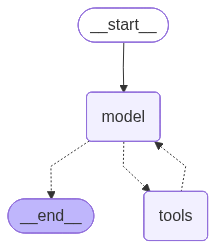

In [34]:
from langchain.agents import create_agent
from langchain_core.prompts import ChatPromptTemplate

system_msg = "You are a research assistant that uses tools like Arxiv, Wikipedia for text summarization and text analysis."

agent = create_agent(
    model=llm,
    tools=tools,
    system_prompt=system_msg
)

agent

### Agent Executor

In [53]:
result = agent.invoke({
    "messages": [{"role": "user", "content": "What is attention all you need research paper all about?"}]
})

final_response = result["messages"][-1].content
print("Output:", final_response)

Output: The "Attention Is All You Need" is a landmark research paper published in 2017 by eight scientists at Google. The paper introduced a new deep learning model architecture, which has been highly influential in the field of machine learning.
